# CNN for Cancer Detection
**Binary image classification of metastatic cancer in tissue samples using a convolutional neural network (CNN).**

#### Background 

This project utilized the Histopathologic Cancer Detection dataset available on Kaggle, which is derived from the PatchCamelyon (PCam) project. The PCam dataset was designed to serve as a benchmark for optimizing deep learning models in image classification tasks. It originally included over 327,000 histological images (96x96 pixels) of lymph node tissue sections, each labeled with a binary indicator denoting the presence metastatic tumors also known as malignant tumors. These cells are cancerous and can spread to other parts of the body, whereas benign tumors are non-cancerous and tend not to spread to other parts of the body. The Kaggle version used in our project is a curated subset of the original PCam data, with duplicate images removed to ensure a clean and reliable dataset.

The Aim of this project will be to create several CNN models based on the test data and to do a binary classification based on the labels.


In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
i = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        i += 1
        if i> 10:
            break
        print(os.path.join(dirname, filename))
    if i > 10:
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
/kaggle/input/histopathologic-cancer-detection/test/5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
/kaggle/input/histopathologic-cancer-detection/test/bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
/kaggle/input/histopathologic-cancer-detection/test/523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
/kaggle/input/histopathologic-cancer-detection/test/d23c66547f4a00555a174d2fcb860ae399b66edc.tif
/kaggle/input/histopathologic-cancer-detection/test/fabf2fca23f71655974767e29eda86a9b2c97a72.tif
/kaggle/input/histopathologic-cancer-detection/test/9730b15862516b8641b9f0ff48db660d95031c32.tif


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Multiply, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-09-15 23:36:38.805849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757979398.829110     932 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757979398.836315     932 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define directories
directory  = '../input/histopathologic-cancer-detection'  
labels_path = os.path.join(directory, 'train_labels.csv')
train_path = os.path.join(directory, 'train')
test_path = os.path.join(directory, 'test')

In [4]:
print('There are ',len(os.listdir(train_path)), 'training images and ',len(os.listdir(test_path)), 'testing images.')

There are  220025 training images and  57458 testing images.


### Data Exploration

In [5]:
# load the CSV file containing labels
labels = pd.read_csv(labels_path)

# create a DataFrame to match training data images with labels
train = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))}) 
train['id'] = train['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])  # Extract image ID to merge with training labels
train = train.merge(labels, on='id')  

# convert labels to strings
train['label'] = train['label'].astype(str)

# ensure paths are relative to train_path
train['path'] = train['path'].apply(lambda x: os.path.basename(x))

print(train.head())

                                           path  \
0  d43c081bafa286f9c1f7e921883f26ceafebc912.tif   
1  092d0eedebce504847715ee046b6ad74b57599b4.tif   
2  b0d2582c6218a8764323fc940b41312282b99bf4.tif   
3  187c99df762f13f99818e5593d4bab4c6577e7e3.tif   
4  7c5270c83837de5a5cbb2dca511559dc39d19d53.tif   

                                         id label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912     1  
1  092d0eedebce504847715ee046b6ad74b57599b4     0  
2  b0d2582c6218a8764323fc940b41312282b99bf4     0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3     1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53     1  


<Axes: xlabel='label'>

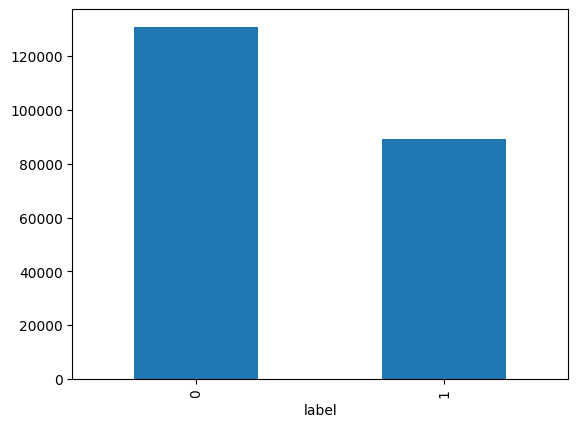

In [6]:
# Check for nulls
train[(train['id'].isnull() | train['path'].isnull())]
# check for counts of 0 and 1 labels
train.groupby(by='label')['id'].count().plot(kind='bar')

The dataset seems to be reasonably balanced (120k vs 80k). We will not try to resample it.

In [7]:
# check for duplicates
print('There are ', train.duplicated().sum(),' duplicated images')

There are  0  duplicated images


Image shape is  (96, 96, 3)
The maximum number of pixels is  255
[243 246 251]


,path,id,label
193666,f62b829cb00e9f1453675ec0d19372db6356e4a3.tif,f62b829cb00e9f1453675ec0d19372db6356e4a3,0


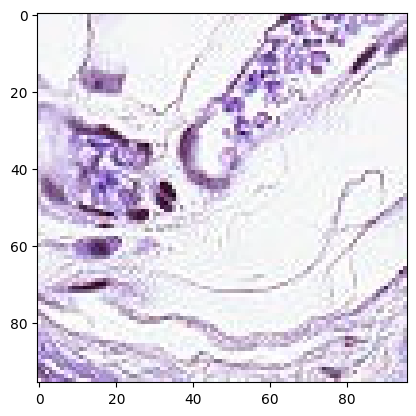

In [8]:
# randomly select one image path
image_path = random.choice(train['path'].values)
# full path to the image
full_image_path = os.path.join(train_path, image_path)
# Load the selected image 
selected_image = cv2.imread(full_image_path)

print('Image shape is ', selected_image.shape)
print('The maximum number of pixels is ', selected_image.max())

# Print 1 pixel
print(selected_image[1,1,:])
plt.imshow(selected_image)
train[train['path'] == image_path] #.split('.')[0]

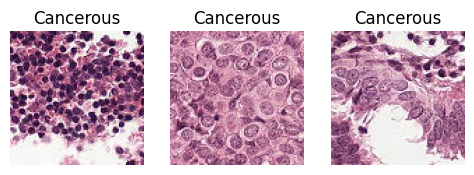

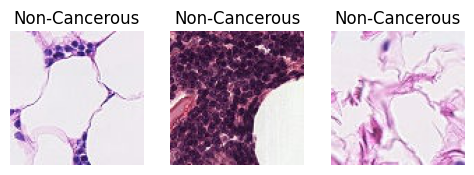

In [9]:
# Separate cancerous and non-cancerous data
cancerous = train[train['label'] == '1']['id'].sample(n=3).values  # Treat labels as strings
noncancerous = train[train['label'] == '0']['id'].sample(n=3).values

cancerous_images = []
for id in cancerous:
    image_path = os.path.join(train_path, id + '.tif')
    cancerous_images.append(Image.open(image_path))

noncancerous_images = []
for id in noncancerous:
    image_path = os.path.join(train_path, id + '.tif')
    noncancerous_images.append(Image.open(image_path))

plt.figure(figsize=(10, 5))
for i, image in enumerate(cancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Cancerous')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i, image in enumerate(noncancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Non-Cancerous')
    plt.axis('off')
plt.show()

## Data Generation

The original dataset with more than 220k images takes a lot of time, and sometimes never finishes. We will resample the data
and only grap 50k from each set



In [10]:
from sklearn.utils import shuffle

c_df = train[train['label'] == '1'].sample(50000, random_state=42)
nc_df = train[train['label'] == '0'].sample(50000, random_state=42)

train_100k = pd.concat([c_df, nc_df], axis = 0).reset_index(drop = True)
train_100k = shuffle(train_100k)
train_100k.shape
                       

(100000, 3)

In [11]:
# Split the data into 80% training and 20% validation sets
train_df, val_df = train_test_split(train_100k, test_size=0.2, random_state=42)

# Data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255  # scale images from 0-255 to 0-1 
)

# Data generator for validation images without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255  # scale images from 0-255 to 0-1
)

batch_size = 64

# Generator for the training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96), # image shape
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Generator for the validation set
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,  
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


### Base custom model
Lets try a very simple base model first.

In [12]:
cnn_baseline = Sequential([
    Conv2D(filters = 32, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (96,96,3)),
    Conv2D(filters = 32, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = [5,5], padding = 'same', activation = 'relu'),
    Conv2D(filters = 128, kernel_size = [5,5], padding = 'same', activation = 'relu'),
    Conv2D(filters = 128, kernel_size = [3,3], padding = 'same', activation = 'relu'),
    MaxPooling2D(2,2),
    Dropout(.2),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_baseline.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757979465.423779     932 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 3,235,425 (12.34 MB)

 Trainable params: 3,234,977 (12.34 MB)

 Non-trainable params: 448 (1.75 KB)

### Hyperparameter Tuning.
We will try multiple values of learning rates:
0.01, 0.001 and 0.0001. We will run these for only 10 epochs due to time constrains.

## Learning rate = 0.01

1250
313


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1757979474.422538     986 service.cc:148] XLA service 0x7b2ff801cea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757979474.422599     986 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757979475.171902     986 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:16 62ms/step - AUC: 0.5632 - loss: 1.0942  

I0000 00:00:1757979483.355111     986 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 105ms/step - AUC: 0.7604 - loss: 0.6637 - val_AUC: 0.7221 - val_loss: 0.6123
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 102ms/step - AUC: 0.8672 - loss: 0.4569 - val_AUC: 0.8780 - val_loss: 0.4591
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - AUC: 0.9164 - loss: 0.3677 - val_AUC: 0.9242 - val_loss: 0.5230
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - AUC: 0.9254 - loss: 0.3481 - val_AUC: 0.9050 - val_loss: 0.4539
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - AUC: 0.9359 - loss: 0.3242 - val_AUC: 0.8588 - val_loss: 0.5175
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - AUC: 0.9412 - loss: 0.3099 - val_AUC: 0.9283 - val_loss: 0.7042
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - AUC: 0.9472 - loss: 0.2935 - val_AUC: 0.8777 - val_loss: 1.1556
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 128s 103ms/step - AUC: 0.9538 - loss: 0.2742 - val_AUC: 0.9423 - val_loss: 0.6803
Epoch 9/10
1250/125

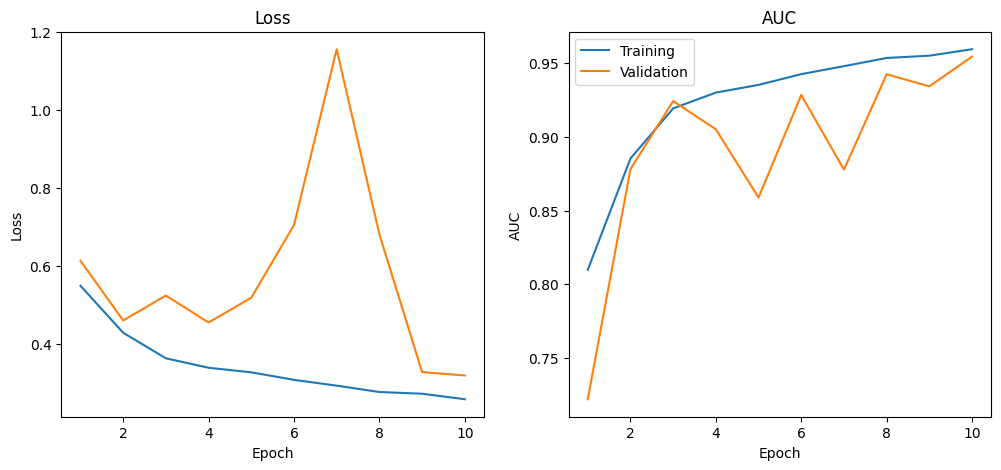

CPU times: user 13min 49s, sys: 2min, total: 15min 50s
Wall time: 21min 30s


In [13]:
%%time
TR_STEPS = len(train_generator)
VAL_STEPS = len(validation_generator)
print(TR_STEPS)
print(VAL_STEPS)
opt = tf.keras.optimizers.Adam(learning_rate = .01)
cnn_baseline.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

h1 = cnn_baseline.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 10,  # No of expochs reduced so that the notebook may finish
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)
history = h1.history

epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()

## Learning rate = 0.001

1250
313
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 108ms/step - AUC: 0.9699 - loss: 0.2197 - val_AUC: 0.9697 - val_loss: 0.2385
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 105ms/step - AUC: 0.9742 - loss: 0.2034 - val_AUC: 0.9688 - val_loss: 0.2474
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 107ms/step - AUC: 0.9742 - loss: 0.2031 - val_AUC: 0.9745 - val_loss: 0.2227
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 105ms/step - AUC: 0.9746 - loss: 0.2007 - val_AUC: 0.9723 - val_loss: 0.2598
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - AUC: 0.9760 - loss: 0.1951 - val_AUC: 0.9754 - val_loss: 0.2265
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - AUC: 0.9775 - loss: 0.1884 - val_AUC: 0.9702 - val_loss: 0.2567
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 128s 102ms/step - AUC: 0.9783 - loss: 0.1850 - val_AUC: 0.9730 - val_loss: 0.2379
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - AUC: 0.9788 - loss: 0.1826 - val_AUC: 0.9637 - val_loss: 0.3212

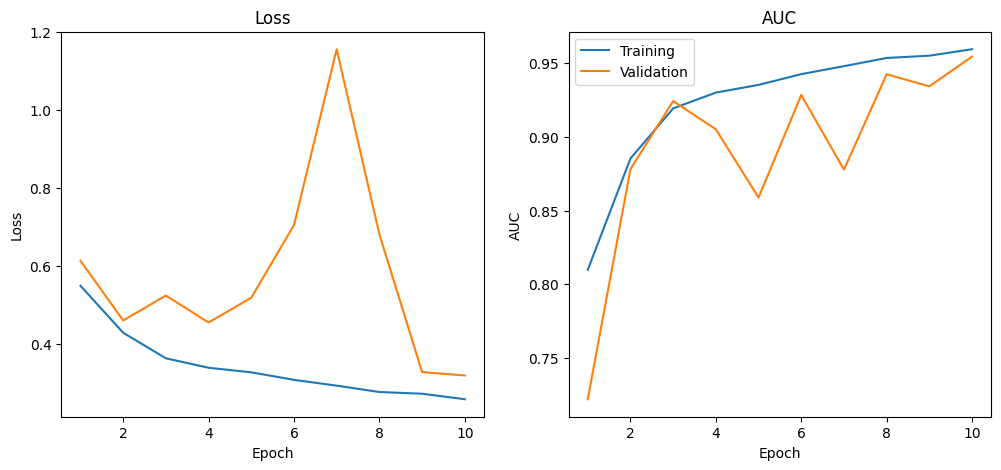

CPU times: user 13min 55s, sys: 2min, total: 15min 55s
Wall time: 21min 55s


In [14]:
%%time
TR_STEPS = len(train_generator)
VAL_STEPS = len(validation_generator)
print(TR_STEPS)
print(VAL_STEPS)
opt = tf.keras.optimizers.Adam(learning_rate = .001)
cnn_baseline.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

h2 = cnn_baseline.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 10,  # No of expochs reduced so that the notebook may finish
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)

epoch_range = range(1, len(h2.history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()


While the training loss goes down to a very low value, the validation loss bounces around before setting at around 0.3947. The validation AUC seems to be pretty good.


## Learning rate = 0.0001

1250
313
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 104ms/step - AUC: 0.9808 - loss: 0.1746 - val_AUC: 0.9772 - val_loss: 0.2261
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 104ms/step - AUC: 0.9810 - loss: 0.1731 - val_AUC: 0.9768 - val_loss: 0.2231
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - AUC: 0.9812 - loss: 0.1738 - val_AUC: 0.9770 - val_loss: 0.2224
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 106ms/step - AUC: 0.9813 - loss: 0.1719 - val_AUC: 0.9769 - val_loss: 0.2243
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 104ms/step - AUC: 0.9813 - loss: 0.1707 - val_AUC: 0.9763 - val_loss: 0.2350
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 130s 104ms/step - AUC: 0.9823 - loss: 0.1666 - val_AUC: 0.9767 - val_loss: 0.2232
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 105ms/step - AUC: 0.9821 - loss: 0.1676 - val_AUC: 0.9755 - val_loss: 0.2367
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 104ms/step - AUC: 0.9825 - loss: 0.1662 - val_AUC: 0.9749 - val_loss: 0.2457

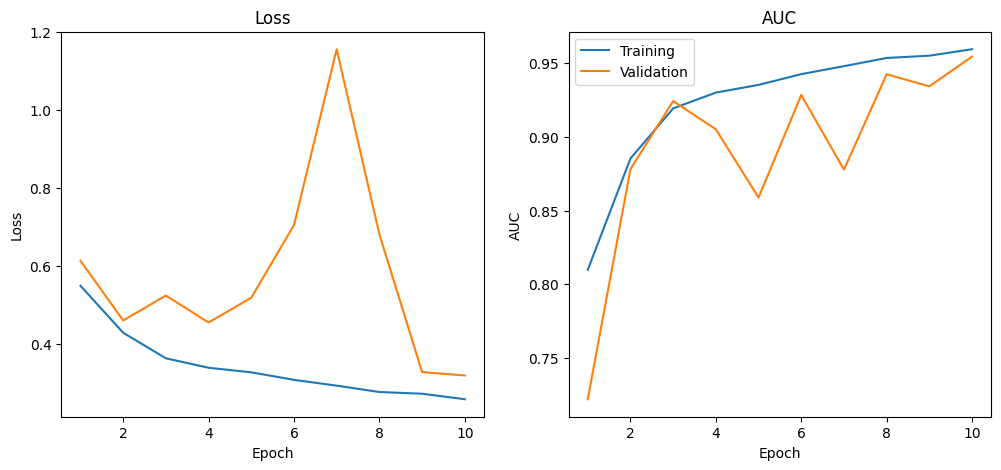

CPU times: user 14min 6s, sys: 2min 1s, total: 16min 8s
Wall time: 22min 5s


In [15]:
%%time
TR_STEPS = len(train_generator)
VAL_STEPS = len(validation_generator)
print(TR_STEPS)
print(VAL_STEPS)
opt = tf.keras.optimizers.Adam(learning_rate = .0001)
cnn_baseline.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

h3 = cnn_baseline.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 10,  # No of expochs reduced so that the notebook may finish
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)

epoch_range = range(1, len(h3.history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()


#### Comparing the learning rates.
This is pretty amazing. With just 10 epochs, we can achieve validation AUC of 0.974

### Final Base model with 30 epochs and learning of 0.0001

1250
313


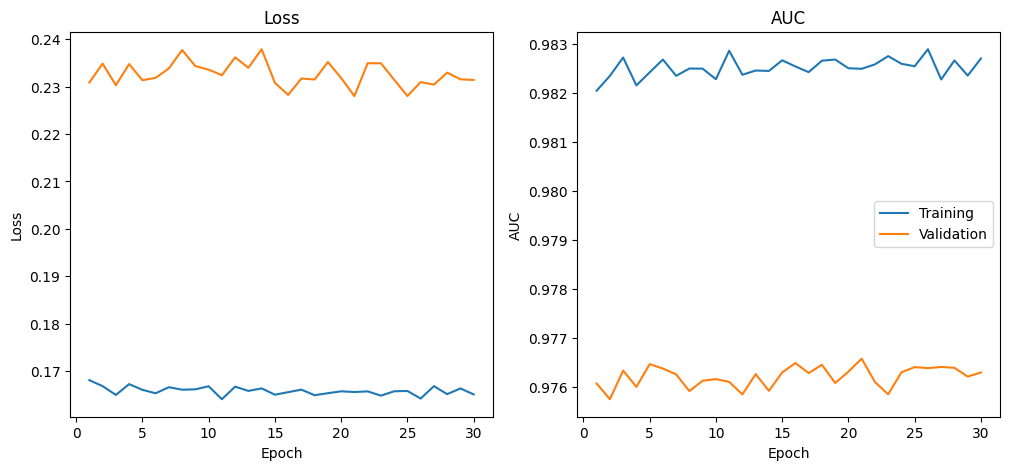

CPU times: user 369 ms, sys: 5.54 ms, total: 374 ms
Wall time: 372 ms


In [18]:
%%time

TR_STEPS = len(train_generator)
VAL_STEPS = len(validation_generator)
print(TR_STEPS)
print(VAL_STEPS)
opt = tf.keras.optimizers.Adam(learning_rate = .00001)
cnn_baseline.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])
"""
h4 = cnn_baseline.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 30,  
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)
"""
history = h4.history
epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()


In [ ]:
!mkdir -p saved_model

cnn_baseline.save('saved_model/base_model.keras')


In [ ]:
!ls -lh saved_model 

### Submit the Base model
Save before we try out the next model

In [19]:
# Load test image paths
test_df = pd.DataFrame({'path': glob(os.path.join(test_path, '*.tif'))})
test_df['id'] = test_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
test_df['filename'] = test_df['id'] + '.tif'
print(test_df.head(5))
print(test_df.info())
print(test_df['path'][0])


                                                path  \
0  ../input/histopathologic-cancer-detection/test...   
1  ../input/histopathologic-cancer-detection/test...   
2  ../input/histopathologic-cancer-detection/test...   
3  ../input/histopathologic-cancer-detection/test...   
4  ../input/histopathologic-cancer-detection/test...   

                                         id  \
0  a7ea26360815d8492433b14cd8318607bcf99d9e   
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664   
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb   
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0   
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62   

                                       filename  
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif  
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif  
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif  
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif  
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data

In [20]:
#Create the test image datagenerator
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    directory=test_path,
                                                    x_col='filename',
                                                    y_col=None,
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False)

Found 57458 validated image filenames.


In [21]:
# Make predictions with test data
test_preds = cnn_baseline.predict(test_generator, verbose=1)
test_preds_probs = (test_preds > 0.5).astype(int)
submission = test_df.copy()
submission = submission.drop(columns=['filename', 'path'])
submission['label'] = test_preds_probs
print('Writing the submission file')
print(submission.head())

submission.to_csv('/kaggle/working/base_submission_1.csv', index=False)
#submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 316s 176ms/step
Writing the submission file
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


#### Resmet101 Transfer Model
Create a model first with transfer learning using *ResNet101*.

ResNet-101 is a convolutional neural network (CNN) and a specific member of the Residual Network (ResNet) family of models. The "101" in its name indicates that it is a very deep network with 101 layers. This indicates that most of the work of detecting edges has already been done.

ResNet's  is surprisingly simple and elegant: it introduces "skip connections" or "shortcut connections" to its architecture. These connections create residual blocks.


In [22]:
from tensorflow.keras import models, layers, datasets

resnet_model = tf.keras.applications.ResNet101(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
resnet_model.trainable = True 



cnn_resnet_model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),


    Dense(128, activation = 'relu'),
    Dropout(.2),
    Dense(64, activation = 'relu'),
    Dropout(.2),
    Dense(32, activation = 'relu'),
    Dropout(.2),
    Dense(1, activation = 'sigmoid')
])
cnn_resnet_model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 3, 3, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,930,817 (163.77 MB)

 Trainable params: 42,825,473 (163.37 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
cnn_resnet_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['AUC'])

## Train the Resnet model
We will train this model only for 20 epochs due to time constrains.


In [27]:
# Commentint out the Resnet model as it takes too long and the notebook times out
#%%time

h5 = cnn_resnet_model.fit(
    x = train_generator,
    steps_per_epoch = TR_STEPS,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = VAL_STEPS,
    verbose = 1,
)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 401s 200ms/step - AUC: 0.4940 - loss: 0.7894 - val_AUC: 0.5813 - val_loss: 0.6870
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 215s 172ms/step - AUC: 0.5522 - loss: 0.7428 - val_AUC: 0.6672 - val_loss: 0.6466
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 214s 171ms/step - AUC: 0.6792 - loss: 0.6453 - val_AUC: 0.8097 - val_loss: 0.5596
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 213s 170ms/step - AUC: 0.7344 - loss: 0.6011 - val_AUC: 0.8492 - val_loss: 0.5178
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 213s 171ms/step - AUC: 0.7607 - loss: 0.5803 - val_AUC: 0.8623 - val_loss: 0.4987
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 212s 170ms/step - AUC: 0.7776 - loss: 0.5638 - val_AUC: 0.8722 - val_loss: 0.4823
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 211s 169ms/step - AUC: 0.7987 - loss: 0.5414 - val_AUC: 0.8804 - val_loss: 0.4663
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 212s 170ms/step - AUC: 0.8110 - loss: 0.5283 - val_AUC: 0.8867 - val_loss: 0.4523
Epoch 

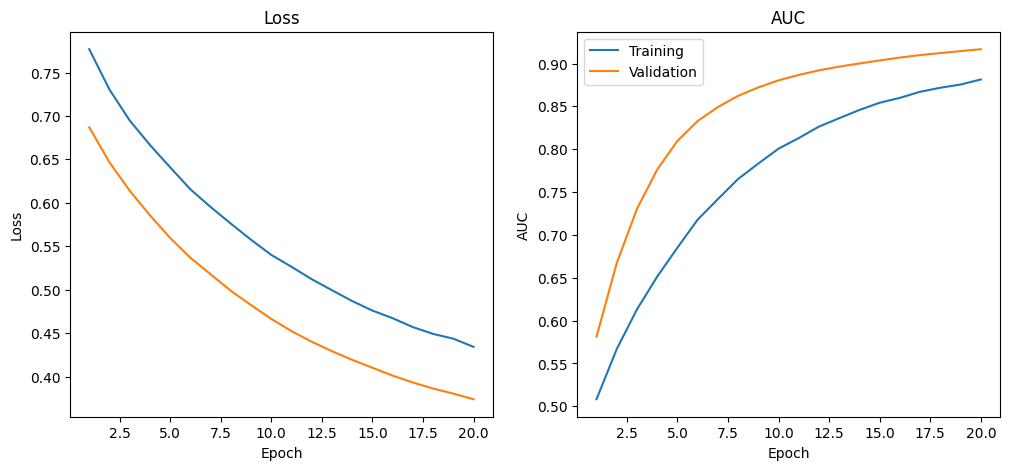

In [28]:
history = h5.history


epoch_range = range(1, len(history['loss'])+1)
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label = 'Training')
plt.plot(epoch_range, history['val_loss'], label = 'Validation')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epoch_range, history['AUC'], label = 'Training')
plt.plot(epoch_range, history['val_AUC'], label = 'Validation')
plt.xlabel("Epoch");plt.ylabel("AUC");plt.title("AUC")
plt.legend()
plt.show()

## Confusion Matrix

Confusion Matrix for our custom model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step


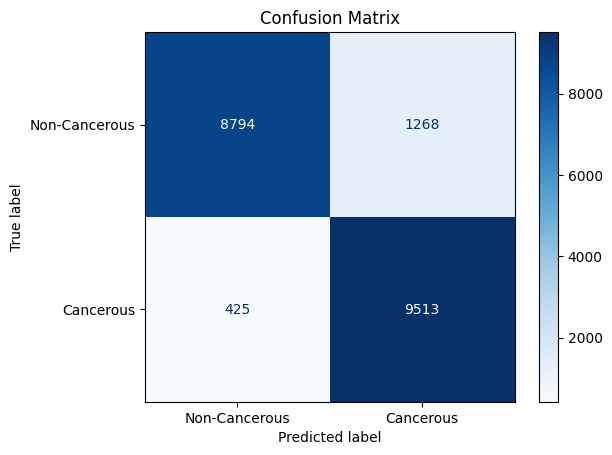

In [29]:
# calculations for confusion matrix
true_labels = validation_generator.classes
pred_probabilities = cnn_baseline.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes = (pred_probabilities > 0.5).astype(int)

# confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save plot to kaggle output directory (optional)
plt.savefig('/kaggle/working/cnn_training_confusion.png', dpi=300)
plt.show()

In [ ]:
# Accuracy 
(9532+8247)/20000

Confusion Matrix for resnet model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step


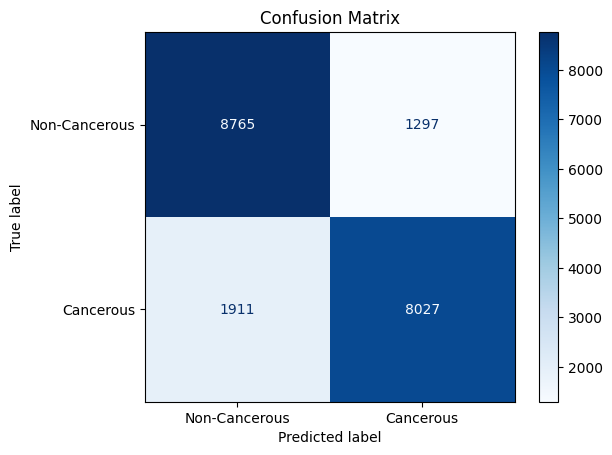

In [31]:
# calculations for confusion matrix
true_labels = validation_generator.classes
pred_probabilities = cnn_resnet_model.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes = (pred_probabilities > 0.5).astype(int)

# confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save plot to kaggle output directory (optional)
plt.savefig('/kaggle/working/cnn_training_confusion.png', dpi=300)
plt.show()

In [ ]:
# Accuracy 
(8871+8667)/20000

### Conclusion 
In this study I tried a basic model and a Resnet Model. I ran in to several difficulties with the model timing out and taking for ever. I figured out that I am just scratching the surface as far as creating an optimal performing CNN goes.

Surprisingly with our initial attempts, the Custom Model works much better than the ResNet101 transfer model. This may can be obviously be improved by increasing the epochs to 100 and retrying. However these experiments are slow to execute and we will conclude with these results with enought to try out in future work.


## Prepare Test Data for Submission

In [32]:
#Create the test image datagenerator
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    directory=test_path,
                                                    x_col='filename',
                                                    y_col=None,
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False)

Found 57458 validated image filenames.


In [33]:
# Make predictions with test data
test_preds = cnn_resnet_model.predict(test_generator, verbose=1)
test_preds_probs = (test_preds > 0.5).astype(int)
submission = test_df.copy()
submission = submission.drop(columns=['filename', 'path'])
submission['label'] = test_preds_probs
print(submission.head())

submission.to_csv('/kaggle/working/submission_resnet2.csv', index=False)
submission.to_csv('submission_resnet.csv', index=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 92s 46ms/step
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      1
